In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,precision_score

In [151]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [152]:
df=pd.read_csv('fake_reviews.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [153]:
df.drop(columns = {'category'}, inplace = True)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [155]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [156]:
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [157]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df
df = encode_label(df)

In [158]:
df['target'].unique()

array([0, 1])

In [159]:
df['target'].dtype

dtype('int64')

In [160]:
df.drop(['rating', 'label'],axis=1, inplace = True)

In [161]:
df.head()

,text,target
0,"Love this! Well made, sturdy, and very comfor...",0
1,"love it, a great upgrade from the original. I...",0
2,This pillow saved my back. I love the look and...,0
3,"Missing information on how to use it, but it i...",0
4,Very nice set. Good quality. We have had the s...,0


In [162]:
df = df.sample(frac=1).reset_index(drop=True)

df.sample(10)

,text,target
18092,I really wasn't sure if I wanted to get this b...,1
25369,Pay for what you get. I have bought many othe...,0
9800,Awesome little flash drive that holds an entir...,0
39038,Good socks. Nice pricing. Excellent quality....,0
6036,OMG THE FEELS!!!!! The numbness I felt at the ...,1
3472,"Maybe more a film for our time now, than for w...",1
9685,gives a very different perception of what the ...,0
26228,OMG! This book will keep you riveted to your s...,1
24092,I can't imagine having to press garlic for hou...,1
23385,"these are great puppy pads, they don't leak th...",1


In [163]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [164]:
df.duplicated().sum()

np.int64(20)

In [165]:
df.drop_duplicates(inplace = True)

In [166]:
df.duplicated().sum()

np.int64(0)

In [167]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

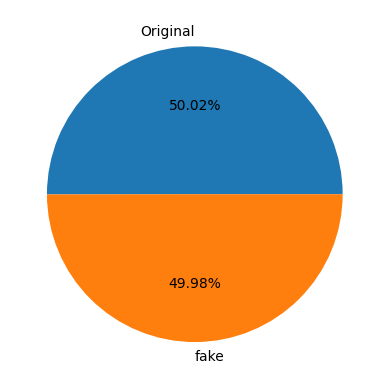

In [168]:
plt.pie(df['target'].value_counts(), labels=['Original', 'fake'],autopct="%.2f%%")
plt.show()

In [169]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [170]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,"After getting stuck in a locked room, the girl...",0,597,153,11
1,Love this keyboard. This is an amazing keyboa...,0,387,91,8
2,Regulator is not a direct replacement for the ...,0,309,63,4
3,My son loves playing with this toy and the mat...,0,576,125,8
4,Great collection of recipes. Do we need anythi...,1,110,23,4


In [171]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.691131,5.277071
std,0.500006,369.871842,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


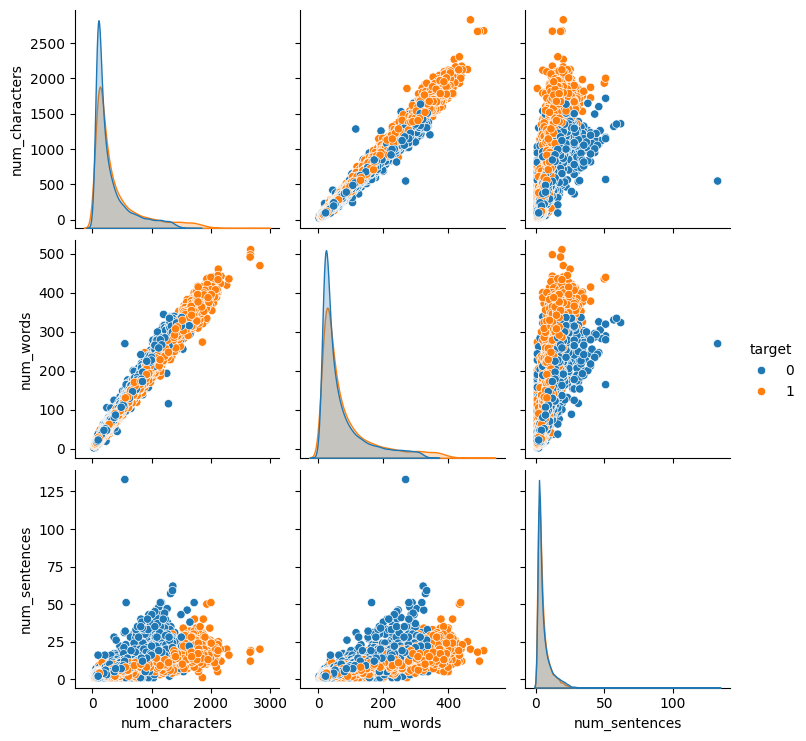

In [172]:
sns.pairplot(df,hue='target')

<Axes: >

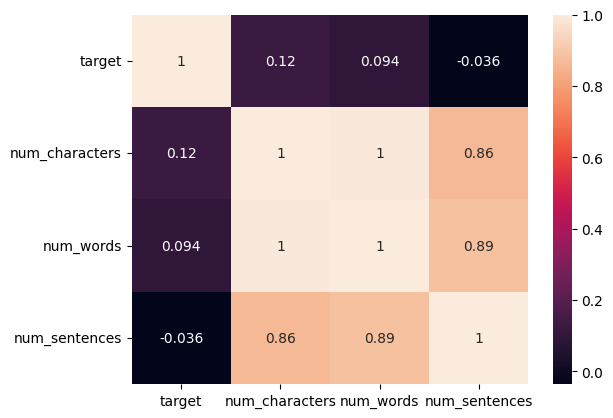

In [173]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [174]:
ps = PorterStemmer()

In [175]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [176]:
transform_text("This was a very good prodcut, I'll recommend this to all those who have a messy kitchen!! Great product, buy it!")

'good prodcut recommend messi kitchen great product buy'

In [177]:
df['transformed_text'] = df['text'].apply(transform_text)

In [178]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,"After getting stuck in a locked room, the girl...",0,597,153,11,get stuck lock room girl get mind girl free gi...
1,Love this keyboard. This is an amazing keyboa...,0,387,91,8,love keyboard amaz keyboard keep review bought...
2,Regulator is not a direct replacement for the ...,0,309,63,4,regul direct replac meter nice bonu one bathro...
3,My son loves playing with this toy and the mat...,0,576,125,8,son love play toy materi good love detail colo...
4,Great collection of recipes. Do we need anythi...,1,110,23,4,great collect recip need anyth els love photo ...


(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

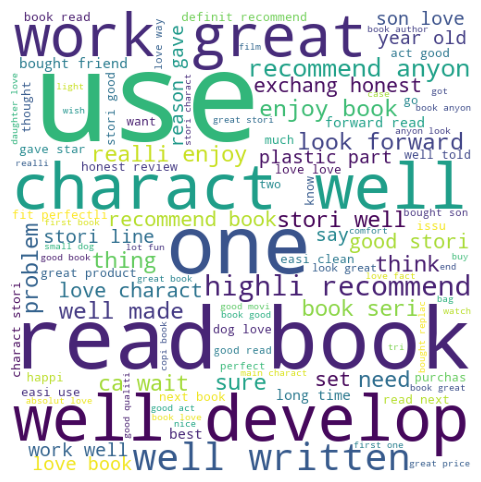

In [179]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(fake_wc)
plt.axis('off')

(np.float64(-0.5), np.float64(499.5), np.float64(499.5), np.float64(-0.5))

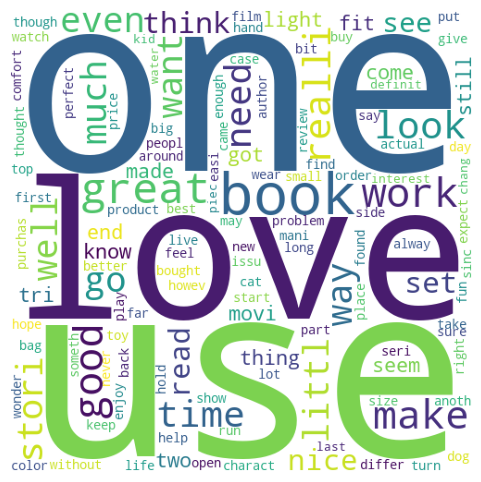

In [180]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(original_wc)
plt.axis('off')

In [181]:
tfidf = TfidfVectorizer(max_features=3000)
x = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [182]:
x.ndim

2

In [183]:
y.ndim

1

In [184]:
print(x.shape)
print(y.shape)

(40412, 3000)
(40412,)


In [185]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [186]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [187]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc
}

In [188]:
def train_classifier(clf,x_train,y_train,x_test,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

In [189]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():    
    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [190]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [191]:
performance_df.reset_index(drop = True)

,Algorithm,Accuracy,Precision
0,LR,0.857231,0.857300
1,NB,0.834962,0.836304
2,RF,0.831993,0.834438
3,DT,0.602252,0.638810
4,KN,0.493134,0.498322


In [192]:
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [193]:
voting = VotingClassifier(estimators=[('LR', lrc), ('nb', mnb), ('RF', rfc)],voting='soft')

In [194]:
voting.fit(x_train,y_train)

,estimators,"[('LR', ...), ('nb', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [195]:
y_pred = voting.predict(x_test)
print('Voting Clssifier- Accuracy and Presion\n________________________________________')
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Voting Clssifier- Accuracy and Presion
________________________________________
Accuracy 0.8681182729184709
Precision 0.8832153690596563


In [196]:
estimators = [('LR', lrc), ('nb', mnb), ('RF', rfc)]
final_estimator = RandomForestClassifier(n_estimators=50, random_state=2)

In [197]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [198]:
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8509216874922677
Precision 0.8604535260403688


In [199]:
pickle.dump(tfidf, open("../app/models/vectorizer.pkl", 'wb'))
pickle.dump(voting, open("../app/models/model.pkl", 'wb'))

In [200]:
sen=['This is a great good product']
sem=tfidf.transform(sen)
pred1=(voting.predict(sem))
print(pred1)
if pred1==0:
    print('Fake or Computer Generated')
else:
    print("genuine or Original")
voting.predict_proba(sem)

[0]
Fake or Computer Generated


array([[0.75220683, 0.24779317]])

In [201]:
print(voting.classes_)

[0 1]
